# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [15]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import torch.nn.functional as F


## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [17]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

def read_data(path):
  # This function import data set from google drive by a given path 
  # and return normalized np array in the needed shape. 
  images = {}
  for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    images[filename] = img[:, :, :3] # remove the alpha channel
  
  data = np.zeros((len(images)//6,3, 2, 224, 224, 3))
  person_num = 0
  for key in sorted(images.keys()):
    _ , pair_num, side, _ = key.split("_")
    pair_num = int(pair_num)-1
    if side == 'left':
      side = 0
    else:
      side = 1
    data[person_num, pair_num, side,:,:,:] = images[key]/255-0.5
    if pair_num == 2 and side == 1:
      person_num += 1

  return data

In [18]:
train_data = read_data("/content/gdrive/My Drive/Colab Notebooks/data/train/*.jpg")
valid_data = train_data[int(0.8*len(train_data)):]
train_data = train_data[:int(0.8*len(train_data))]
test_w = read_data("/content/gdrive/My Drive/Colab Notebooks/data/test_w/*.jpg")
test_m = read_data("/content/gdrive/My Drive/Colab Notebooks/data/test_m/*.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


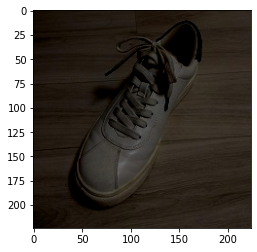

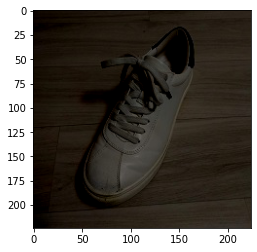

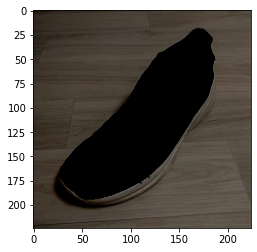

In [19]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


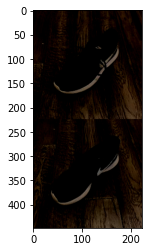

In [20]:
def generate_same_pair(data):
  # this function takes data in size [x, 3, 2, 224, 224, 3] and return an array
  # in size [x*3, 448, 224, 3] of each pairs of shoes concatinated.
  tmp = np.zeros((data.shape[0]*data.shape[1],448,224,3))
  for person in range(data.shape[0]):
    for pair_num in range(data.shape[1]):
       tmp[person*3+pair_num,:,:,:] = np.concatenate((data[person,pair_num,0,:,:,:],data[person,pair_num,1,:,:,:]),axis=0)
  return tmp

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(89, 3, 2, 224, 224, 3)
(267, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


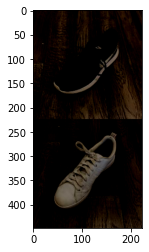

In [21]:
def generate_different_pair(data):
  # this function takes data in size [x, 3, 2, 224, 224, 3] and return an array
  # in size [x*3, 448, 224, 3] of two shoes of different pairs concatinated.
  tmp = np.zeros((data.shape[0]*data.shape[1],448,224,3))
  for person in range(data.shape[0]):
       tmp[person*3,:,:,:] = np.concatenate((data[person,0,0,:,:,:],data[person,1,1,:,:,:]),axis=0)  # right 0 with 1 left
       tmp[person*3+1,:,:,:] = np.concatenate((data[person,1,0,:,:,:],data[person,2,1,:,:,:]),axis=0)   # right 1 with 2 left
       tmp[person*3+2,:,:,:] = np.concatenate((data[person,2,0,:,:,:],data[person,0,1,:,:,:]),axis=0)   # right 2 with 0 left
  return tmp


# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0]) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**

We want our network to learn to detect shoes that are not similar based on the actual shoes and not based on the others image details. 
Different pairs of shoes that are taken by the same person still share a lot of similaraties. For example, they have the same background, and are (probably) taken with the same camera under the same lighting conditions.


### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**

If 99% of the images were of shoes that are not the same pair, the network might be really good at detecting shoes that are not the same pair, but would be very poor at detecting shoes that are the same pair. 
So it is important that our data set be balanced for the purpose that our model will be able to detect both cases (true negative, true positive) in high probability. 

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [22]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n, kernel_size=5,  padding = int((5-1) / 2))
        self.conv2 = nn.Conv2d(self.n, 2*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.conv3 = nn.Conv2d(2*self.n, 4*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.conv4 = nn.Conv2d(4*self.n, 8*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.fc1 = nn.Linear(int(8*n*(448/16)*(224/16)), out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 2)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride = 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [23]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        self.n = n
        self.conv1 = nn.Conv2d(in_channels= 6, out_channels=self.n, kernel_size=5,  padding = int((5-1) / 2))
        self.conv2 = nn.Conv2d(self.n, 2*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.conv3 = nn.Conv2d(2*self.n, 4*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.conv4 = nn.Conv2d(4*self.n, 8*self.n, kernel_size=5, padding = int((5-1) / 2))
        self.fc1 = nn.Linear(int(8*n*(224/16)*(224/16)), out_features = 100)
        self.fc2 = nn.Linear(in_features = 100, out_features = 2)

    def forward(self, x, verbose=False):
        shoe1 = x[:, :, :224, :]
        shoe2 = x[:, :, 224:, :]

        x = torch.cat(tensors = (shoe1,shoe2),dim = 1)

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2,stride = 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride = 2)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x

## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**

We think that the second model should be better because when we pack the images one above the other, we loose the main property of convolution which is the Locality, i.e. the kernel in the first model do not take in calculation two pixels from two shoes in the same location in the image, on the other hand, the kernel in the second model calculate the same pixel (in relative to the image) of both shoes.

in other words, if we want to compare two images of two shoes, we need to compare each pixel in the same location in both images. the second model kind of doing exactly that.


## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**

Our training data was split into 2 seperate sets. For example, if we see that all of the network's mistakes are false positives, we may conclude that there's a problem with the training data consisting of pairs of shoes.
More generally, we would like that our model will have good results in the negative labels and in the positive labels, so it would be usefull to know the results on each set.

In [24]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(np.transpose(data_pos[i:i+batch_size],(0,3,1,2)))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(np.transpose(data_neg[i:i+batch_size],(0,3,1,2)))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the  max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [25]:
def train_model (model,
                  train_data,
                  validation_data,
                  batch_size=50,
                  learning_rate=0.001,
                  weight_decay=0,
                  max_iters = 100000,
                  epochs=20,
                  checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_pos_accs,train_neg_accs, val_pos_accs, val_neg_accs = [], [] ,[], [], []

    train_pos_data = generate_same_pair(train_data)
    train_neg_data = generate_different_pair(train_data)

    # xt = np.zeros([batch_size,448,224,3])
    # st = np.zeros(batch_size)

    batch_size = batch_size//2
    n = 0 # the number of iterations
    epoch = 0 # the number of epochs
    while True:
        # Shuffle and genrate mix positive and negative train data and labels.
        reindex = np.random.permutation(train_pos_data.shape[0])
        train_pos_data = train_pos_data[reindex]

        reindex = np.random.permutation(train_neg_data.shape[0])
        train_neg_data = train_neg_data[reindex]

        for i in range(0, train_pos_data.shape[0], batch_size):
            if (i + batch_size) > train_pos_data.shape[0]:
                break

            # get the input and targets of a minibatch
            reindex = np.random.permutation(batch_size*2)
            xt = np.concatenate((train_pos_data[i:i+batch_size],train_neg_data[i:i+batch_size]),axis=0)[reindex]
            st = np.concatenate((np.ones(batch_size, dtype=int),np.zeros(batch_size, dtype=int)),axis=0)[reindex]
  
             # Reshape training images to [N,C,H,W]
            xt_reshaped = np.transpose(xt,(0, 3, 1, 2))

            # convert from numpy arrays to PyTorch tensors
            xt_tensor = torch.Tensor(xt_reshaped)
            st_tensor = torch.Tensor(st).long()
           

            zs = model(xt_tensor)                 # compute prediction logit
            loss = criterion(zs,st_tensor)                 # compute the total loss
            optimizer.zero_grad()                   # a clean up step for PyTorch
            loss.backward()                         # compute updates for each parameter
            optimizer.step()                        # make the updates for each parameter
            
            # save the current training information
            iters.append(n)
            losses.append(float(loss))  # compute *average* loss


            if n > max_iters:
                return np.array(iters), np.array(losses), np.array(iters_sub), np.array(train_pos_accs), np.array(train_neg_accs), np.array(val_pos_accs), np.array(val_neg_accs)
            n += 1



        
        iters_sub.append(n)
        train_cost = float(loss.detach().numpy())
        train_pos_acc, train_neg_acc = get_accuracy(model, train_data,2*batch_size)
        train_pos_accs.append(train_pos_acc)
        train_neg_accs.append(train_neg_acc)
        val_pos_acc, val_neg_acc = get_accuracy(model, validation_data,2*batch_size)
        val_pos_accs.append(val_pos_acc)
        val_neg_accs.append(val_neg_acc)
        print("epoch %d. [Val positive Acc %.0f%%] [Val negative Acc %.0f%%] [Train positive Acc %.0f%%] [Train negative Acc %.0f%%, Loss %f]" % (
              epoch, val_pos_acc * 100, val_neg_acc * 100, train_pos_acc * 100, train_neg_acc * 100, train_cost))

        if checkpoint_path is not None:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))

            # increment the epoch number
        epoch += 1

        if epoch > epochs:
            return np.array(iters), np.array(losses), np.array(iters_sub), np.array(train_pos_accs), np.array(train_neg_accs), np.array(val_pos_accs), np.array(val_neg_accs)



In [26]:
def plot_learning_curve(iters, losses, iters_sub, train_pos_accs, train_neg_accs, val_pos_accs, val_neg_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, (train_pos_accs+train_neg_accs)/2, label="Train")
    plt.plot(iters_sub, (val_pos_accs + val_neg_accs)/2, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

In [27]:
CNN_Sanity = CNN()
CNNChannel_Sanity = CNNChannel()

epoch 0. [Val positive Acc 100%] [Val negative Acc 0%] [Train positive Acc 100%] [Train negative Acc 0%, Loss 0.693263]
epoch 1. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.694683]
epoch 2. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 50%] [Train negative Acc 50%, Loss 0.693167]
epoch 3. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.693251]
epoch 4. [Val positive Acc 100%] [Val negative Acc 0%] [Train positive Acc 100%] [Train negative Acc 0%, Loss 0.693364]


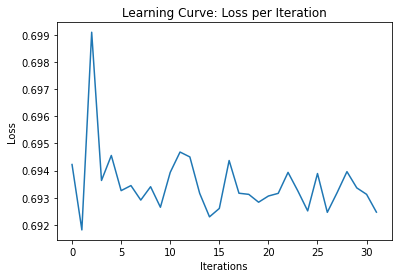

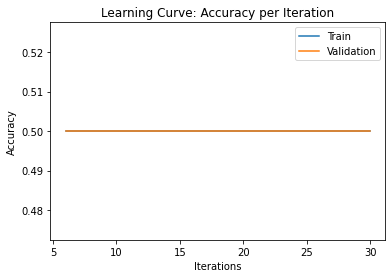

epoch 0. [Val positive Acc 100%] [Val negative Acc 0%] [Train positive Acc 100%] [Train negative Acc 0%, Loss 0.694097]
epoch 1. [Val positive Acc 100%] [Val negative Acc 0%] [Train positive Acc 100%] [Train negative Acc 0%, Loss 0.693303]
epoch 2. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 33%] [Train negative Acc 100%, Loss 0.692977]
epoch 3. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.693184]
epoch 4. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.692902]
epoch 5. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.692281]
epoch 6. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.693104]
epoch 7. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.691888]
epoch 8. [Val positive Acc 67%] [Val ne

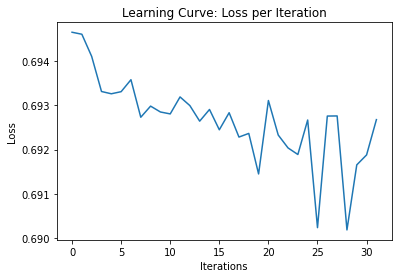

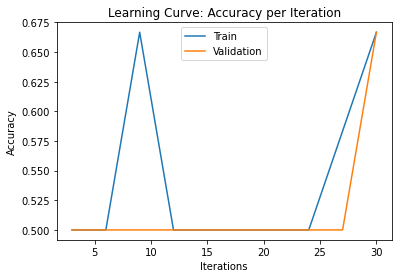

In [28]:
train_data_Sanity = train_data [:2]
valid_data_Sanity = valid_data [:1]

learning_curve_CNN = train_model(CNN_Sanity, train_data_Sanity, valid_data_Sanity, batch_size = 2, learning_rate = 5e-4, weight_decay = 0.0001, max_iters = 30)
plot_learning_curve(*learning_curve_CNN)

learning_curve_CNNChannel = train_model(CNNChannel_Sanity, train_data_Sanity, valid_data_Sanity, batch_size = 4, learning_rate = 0.0001, weight_decay = 0.0001, max_iters = 30)
plot_learning_curve(*learning_curve_CNNChannel)

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**

The first model`s loss did not decreased from epoch to the next epoch regardless the hyperparameters, so we checked the different hyperparameters mostly on the second model.

In order to tuned our hyperparameters we made big changes in the learning rate, batch size and epochs.
First we tryed to find the learning rate, we started with lr=0.001 and we saw that the loss curve decreased fastly in the beginning of the training but then after few epochs started to increase. So we reduced the lr until we got more smooth and more graduetly decrease in the loss curve.
next, we tried to find the best batch size, we began with batch size 8 and saw again that the loss was very noisy, so we increaed the batch size until we found that with batch size 50 the loss curve is less noisy.
then we tund the "n" (channels) and we didnt notice a big changes in the results.


In [29]:
CNN = CNN()
CNNChannel = CNNChannel()

In [30]:
learning_curve_CNN = train_model(CNN, train_data, valid_data, batch_size = 40, learning_rate = 1e-4, weight_decay = 0.0001, epochs = 10, checkpoint_path = '/content/gdrive/My Drive/Colab Notebooks/model_parameters/CNN/ckpt-{}.pk')

epoch 0. [Val positive Acc 100%] [Val negative Acc 3%] [Train positive Acc 92%] [Train negative Acc 10%, Loss 0.693265]
epoch 1. [Val positive Acc 30%] [Val negative Acc 71%] [Train positive Acc 21%] [Train negative Acc 81%, Loss 0.693386]
epoch 2. [Val positive Acc 33%] [Val negative Acc 70%] [Train positive Acc 21%] [Train negative Acc 83%, Loss 0.693028]
epoch 3. [Val positive Acc 1%] [Val negative Acc 99%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.693530]
epoch 4. [Val positive Acc 6%] [Val negative Acc 97%] [Train positive Acc 4%] [Train negative Acc 98%, Loss 0.693400]
epoch 5. [Val positive Acc 28%] [Val negative Acc 78%] [Train positive Acc 20%] [Train negative Acc 85%, Loss 0.693881]
epoch 6. [Val positive Acc 100%] [Val negative Acc 1%] [Train positive Acc 100%] [Train negative Acc 1%, Loss 0.692971]
epoch 7. [Val positive Acc 100%] [Val negative Acc 3%] [Train positive Acc 99%] [Train negative Acc 2%, Loss 0.693635]
epoch 8. [Val positive Acc 9%] [Val negative

In [31]:
learning_curve_CNNChannel = train_model(CNNChannel, train_data, valid_data, batch_size = 40, learning_rate = 0.0003, weight_decay = 0.0001 ,epochs = 15, checkpoint_path = "/content/gdrive/My Drive/Colab Notebooks/model_parameters/CNNchannel/epoch{}.pk" )

epoch 0. [Val positive Acc 0%] [Val negative Acc 100%] [Train positive Acc 0%] [Train negative Acc 100%, Loss 0.692461]
epoch 1. [Val positive Acc 86%] [Val negative Acc 55%] [Train positive Acc 92%] [Train negative Acc 48%, Loss 0.680407]
epoch 2. [Val positive Acc 93%] [Val negative Acc 67%] [Train positive Acc 91%] [Train negative Acc 63%, Loss 0.561917]
epoch 3. [Val positive Acc 81%] [Val negative Acc 88%] [Train positive Acc 78%] [Train negative Acc 81%, Loss 0.526871]
epoch 4. [Val positive Acc 81%] [Val negative Acc 88%] [Train positive Acc 81%] [Train negative Acc 86%, Loss 0.579833]
epoch 5. [Val positive Acc 90%] [Val negative Acc 83%] [Train positive Acc 91%] [Train negative Acc 73%, Loss 0.531228]
epoch 6. [Val positive Acc 88%] [Val negative Acc 88%] [Train positive Acc 85%] [Train negative Acc 84%, Loss 0.341664]
epoch 7. [Val positive Acc 91%] [Val negative Acc 84%] [Train positive Acc 91%] [Train negative Acc 80%, Loss 0.416956]
epoch 8. [Val positive Acc 90%] [Val neg

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

CNN model:

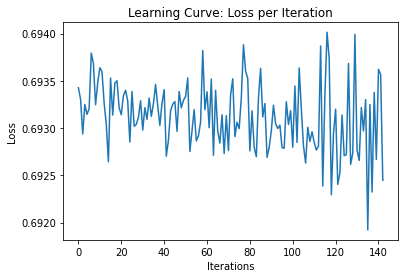

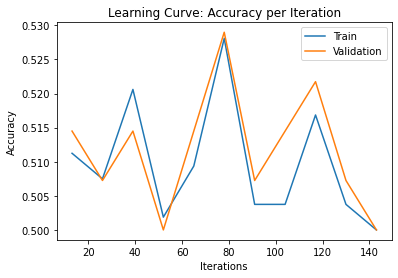

In [32]:
plot_learning_curve(*learning_curve_CNN)

CNN Channel:

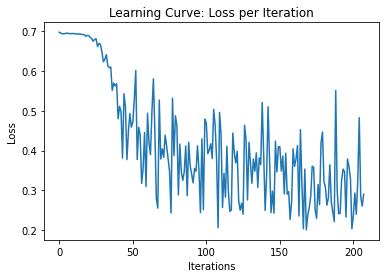

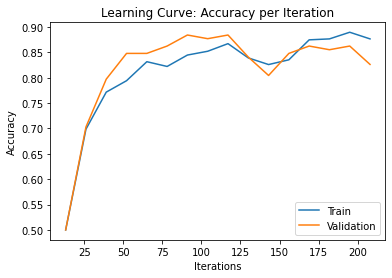

In [33]:
plot_learning_curve(*learning_curve_CNNChannel)

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [34]:
def get_test_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pred_pos , pred_neg = [], []

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(np.transpose(data_pos[i:i+batch_size],(0,3,1,2)))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pred_pos.append(pred)
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(np.transpose(data_neg[i:i+batch_size],(0,3,1,2)))
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the  max logit
        pred = pred.detach().numpy()
        pred_neg.append(pred)
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3), np.array(pred_pos).flatten(), np.array(pred_neg).flatten(),data_pos,data_neg


In [39]:
CNNChannel.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/model_parameters/CNNchannel/epoch14.pk"))

pos_acc_w, neg_acc_w ,pred_pos_w, pred_neg_w, data_pos_w,data_neg_w = get_test_accuracy(CNNChannel, test_w, 50)
pos_acc_m, neg_acc_m ,pred_pos_m, pred_neg_m, data_pos_m,data_neg_m = get_test_accuracy(CNNChannel, test_m, 50)

print("The test_w positive (same pair) accuracy: ", pos_acc_w)
print("The test_w negative (diffrent pair) accuracy: ", neg_acc_w)
print("The test_m positive (same pair) accuracy: ", pos_acc_m)
print("The test_m negative (diffrent pair) accuracy: ", neg_acc_m)



The test_w positive (same pair) accuracy:  0.9
The test_w negative (diffrent pair) accuracy:  0.8666666666666667
The test_m positive (same pair) accuracy:  0.8666666666666667
The test_m negative (diffrent pair) accuracy:  0.8


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


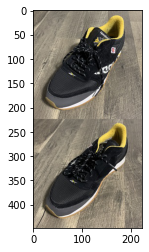

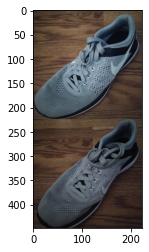

In [40]:
# Plot correct clasfication of the model of two man shoes from the same pair (true positive).
i = 0
for pred in pred_pos_m:
  if pred == 1:
    plt.figure()
    plt.imshow(data_pos_m[i]+0.5) 
    break
  i += 1  

# Plot incorrect clasfication of the model of two man shoes from the same pair (false positive).
i = 0
for pred in pred_pos_m:
  if pred == 0:
    plt.figure()
    plt.imshow(data_pos_m[i]+0.5) 
    break
  i += 1 






### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

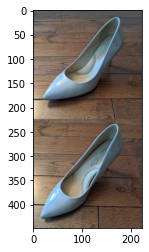

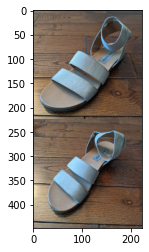

In [41]:
# Plot correct clasfication of the model of two woman shoes from the same pair (true positive).
i = 0
for pred in pred_pos_w:
  if pred == 1:
    plt.figure()
    plt.imshow(data_pos_w[i]+0.5) 
    break
  i += 1  

# Plot incorrect clasfication of the model of two woman shoes from the same pair (false positive).
i = 0
for pred in pred_pos_w:
  if pred == 0:
    plt.figure()
    plt.imshow(data_pos_w[i]+0.5) 
    break
  i += 1 



